In [1]:
import numpy as np
import matplotlib.pyplot as plt
#H='/Users/hongwang/Downloads/plot_uq_erescale/noise_noiserescale/uq_noise_rescale_noiserescalr/'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
H_d='/content/drive/My Drive/galaxy_deblur/new_10k_data/dropout/'
!ls '/content/drive/My Drive/galaxy_deblur/new_10k_data/dropout/'

3630kde_axis.png  5870.png
3630kde.png	  dropout.png
3630.png	  kde.png
520kde_axis.png   new_data_dropout_original_clamp.npz
520kde.png	  new_data_dropout_original.npz
520.png		  uq_dropout_noise_rescale_noiserescale_clamp
5870kde_axis.png  uq_dropout_rescale_clamp
5870kde.png	  uq_dropout_rescale_clamp_1


In [4]:
#quadrature add
sadd = lambda x,y : np.sqrt(x**2+y**2)
def three_bins(q): # split quantity in three bins
    N=len(q)
    mlim1, mlim2 = np.sort(q)[[N//3, 2*N//3]]
    bin1 = np.where(q<=mlim1)
    bin2 = np.where((q>mlim1)&(q<=mlim2))
    bin3 = np.where((q>mlim2))
    return bin1,bin2,bin3

In [5]:
# True data
o_d = np.load(H_d+'new_data_dropout_original_clamp.npz')
## this one still has the old definition, so we need to calculate
#e1_pred = (o['Mu20_pred']-o['Mu02_pred'])/(o['Mu20_pred']+o['Mu02_pred'])
#e2_pred = (2*o['Mu11_pred'])/(o['Mu20_pred']+o['Mu02_pred'])
e1_pred_d = o_d['e1_pred']
e2_pred_d = o_d['e2_pred']
print(e1_pred_d.min(),e1_pred_d.max())
print(e2_pred_d.min(),e2_pred_d.max())

-0.7576643824577332 0.7470070123672485
-0.8017829656600952 0.8305540084838867


In [6]:
mag = np.log10(o_d['M00_true'])

# let's make three mag bins.
mbin1, mbin2, mbin3 = three_bins(mag)
print(mbin1)
print(mbin2)
print(mbin3)

(array([   0,    2,   11, ..., 9990, 9994, 9998]),)
(array([   1,    5,    6, ..., 9993, 9996, 9997]),)
(array([   3,    4,   10, ..., 9989, 9995, 9999]),)


In [7]:
print(np.sum(mbin1[0]==1891))
print(np.sum(mbin2[0]==1891))
print(np.sum(mbin3[0]==1891))

0
0
1


In [8]:
## Let's get noise realizations
noise_e1_d = []
noise_e2_d = []

In [9]:
for i in range(200):
    if i<110:
      t_d = np.load(H_d+f'uq_dropout_rescale_clamp_1/results_dropout{i}.npz')
    else:
      t_d = np.load(H_d+f'uq_dropout_rescale_clamp/results_dropout{i}.npz')
    noise_e1_d.append(t_d['e1_pred'])
    noise_e2_d.append(t_d['e2_pred'])
    if i==0:
        e1_true_d = t_d['e1_true']
        e2_true_d = t_d['e2_true']

In [10]:
e1_noise_d = np.array(noise_e1_d).T
e2_noise_d = np.array(noise_e2_d).T
print(e1_noise_d.shape)
print(e2_noise_d.shape)

(10000, 200)
(10000, 200)


In [11]:
## Let's get noise realizations
noise_e1_n = []
noise_e2_n = []

In [12]:
for i in range(200):
    t_n = np.load(H_d+f'uq_dropout_noise_rescale_noiserescale_clamp/results_dropout_noise{i}.npz')
    noise_e1_n.append(t_n['e1_pred'])
    noise_e2_n.append(t_n['e2_pred'])
    if i==0:
        e1_true_n = t_n['e1_true']
        e2_true_n = t_n['e2_true']

In [13]:
e1_noise_n = np.array(noise_e1_n).T
e2_noise_n = np.array(noise_e2_n).T
print(e1_noise_n.shape)
print(e2_noise_n.shape)

(10000, 200)
(10000, 200)


In [14]:
import scipy.stats as st
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

In [64]:
def kde(k):
  # Additive noise
  # data1 = np.random.multivariate_normal((0, 0), [[0.8, 0.05], [0.05, 0.7]], 100)
  # x1 = data1[:, 0]
  # y1 = data1[:, 1]
  x1 = e1_noise_n[k]
  y1 = e2_noise_n[k]

  # MC dropout
  # data2 = np.random.multivariate_normal((0, 0), [[0.2, 0.03], [0.09, 1.1]], 100)
  # x2 = data2[:, 0]
  # y2 = data2[:, 1]
  x2 = e1_noise_d[k]
  y2 = e2_noise_d[k]

  # xmin, xmax = min(x1.min(), x2.min()), max(x1.max(), x2.max())
  # ymin, ymax = min(y1.min(), y2.min()), max(y1.max(), y2.max())
  
  xmin, xmax = 0.1, 0.3
  ymin, ymax = 0.15, 0.40

  # print(xmin, xmax)
  # print(ymin, ymax)

###################################################
###################################################

  # Peform the kernel density estimate
  xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
  positions = np.vstack([xx.ravel(), yy.ravel()])

  values1 = np.vstack([x1, y1])
  kernel1 = st.gaussian_kde(values1)
  f1 = np.reshape(kernel1(positions).T, xx.shape)

  values2 = np.vstack([x2, y2])
  kernel2 = st.gaussian_kde(values2)
  f2 = np.reshape(kernel2(positions).T, xx.shape)

  # Plotting
  fig = plt.figure()
  ax = fig.gca()
  ax.set_xlim(xmin, xmax)
  ax.set_ylim(ymin, ymax)

  # Contourf plot
  cfset1 = ax.contourf(xx, yy, f1, levels=1, colors=['w', 'r'], alpha=0.4)

  # # or kernel density estimate plot instead of the contourf plot
  # ax.imshow(np.rot90(f1), cmap='Reds', extent=[xmin, xmax, ymin, ymax])

  cfset2 = ax.contourf(xx, yy, f2, levels=1, colors=['w', 'b'], alpha=0.4)
  # # or kernel density estimate plot instead of the contourf plot
  # ax.imshow(np.rot90(f2), cmap='Blues', extent=[xmin, xmax, ymin, ymax])
  print(e1_true_n[k], e2_true_n[k])
  print(e1_true_d[k], e2_true_d[k])
  m1, = plt.plot(e1_true_n[k], e2_true_n[k], '*', color = 'k', markersize = 8, linewidth=10, label='Ground Truth')
  m2, = plt.plot(e1_pred_d[k], e2_pred_d[k], 'x', color = 'r', markersize = 8, linewidth=10, label='Prediction')
  
  ax.set_xlabel('e1')
  ax.set_ylabel('e2')

  #proxy = [plt.Rectangle((1, 1), 2, 2, fc=cs.collections.get_facecolor()[0]) for cs in [cfset1, cfset2]]
  #plt.legend(proxy, ["Additional Noise", "MC Dropout"])
  proxy = [m1, m2, plt.Rectangle((1, 1), 2, 2, fc=cfset1.collections[1].get_facecolor()[0]), plt.Rectangle((1, 1), 2, 2, fc=cfset2.collections[1].get_facecolor()[0])]
  plt.legend(proxy, ['Ground truth', 'Prediction', "Add noise", "MC Dropout"])
  #plt.legend()
  #plt.legend(cfset1.legend_elements()[0], cfset2.legend_elements()[1])

  # axins1 = zoomed_inset_axes(ax, 2.8, loc='upper left')
  # axins1.contourf(xx, yy, f1, levels=1, colors=['w', 'r'], alpha=0.4)
  # axins1.contourf(xx, yy, f2, levels=1, colors=['w', 'b'], alpha=0.4)
  # p1 = axins1.plot(e1_true_n[k], e2_true_n[k], '*', color = 'k', markersize = 8, linewidth=10)
  # p2 = axins1.plot(e1_pred_d[k], e2_pred_d[k], 'x', color = 'r', markersize = 8, linewidth=10)
  # axins1.set_xlim(0.028, 0.072)
  # axins1.set_ylim(0.116, 0.159)
  # mark_inset(ax, axins1, loc1=1, loc2=3, fc="none", ec="0.5")

  # plt.xticks(visible=False)
  # plt.yticks(visible=False)
  # plt.draw()

  plt.tight_layout()
  plt.savefig(H_d+str(k)+'kde_axis.png',bbox_inches='tight')
  plt.show()

0.21978479623794556 0.2772868871688843
0.21978479623794556 0.2772868871688843


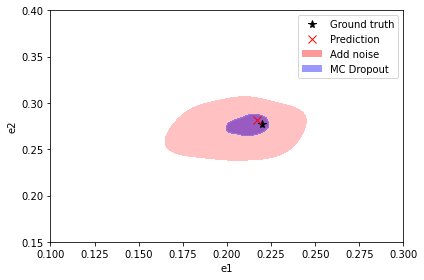

In [65]:
kde(8500)

0.05603835731744766 0.13523243367671967
0.05603835731744766 0.13523243367671967


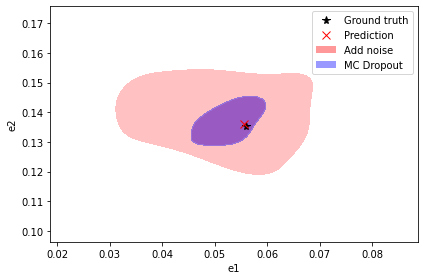

In [22]:
#kde(1891)
#kde(5015)
#kde(5555)

#kde(6461)
kde(3630)


In [17]:
print(e1_noise_d.shape)
list1_low, list2_low = [], []
for i in mbin1[0]:
  list1_low.append(abs(e1_pred_d[i]-e1_true_d[i]))
  list2_low.append(abs(e2_pred_d[i]-e2_true_d[i]))
list1_low = np.array(list1_low)
list2_low = np.array(list2_low)
print(list1_low.mean())
print(list2_low.mean())
list1_medium, list2_medium = [], []
for i in mbin2[0]:
  list1_medium.append(abs(e1_pred_d[i]-e1_true_d[i]))
  list2_medium.append(abs(e2_pred_d[i]-e2_true_d[i]))
list1_medium = np.array(list1_medium)
list2_medium = np.array(list2_medium)
print(list1_medium.mean())
print(list2_medium.mean())
list1_high, list2_high = [], []
for i in mbin3[0]:
  list1_high.append(abs(e1_pred_d[i]-e1_true_d[i]))
  list2_high.append(abs(e2_pred_d[i]-e2_true_d[i]))
list1_high = np.array(list1_high)
list2_high = np.array(list2_high)
print(list1_high.mean())
print(list2_high.mean())

(10000, 200)
0.12853750398400066
0.13286623293896824
0.11221439476945597
0.11480311091767151
0.057073083931189546
0.05705429377075447


In [26]:
print(e1_noise_d.shape)
for i in mbin1[0]:
  if abs(e1_pred_d[i]-e1_true_d[i])<=0.06 and abs(e2_pred_d[i]-e2_true_d[i])<=0.06:
    print('low m00', i)
    kde(i)
# for i in mbin2[0]:
#   if abs(e1_pred_d[i]-e1_true_d[i])<=0.04 and abs(e2_pred_d[i]-e2_true_d[i])<=0.04:
#     print('medium m00', i)
#     kde(i)
# for i in mbin3[0]:
#   if abs(e1_pred_d[i]-e1_true_d[i])<=0.02 and abs(e2_pred_d[i]-e2_true_d[i])<=0.02:
#     print('high m00', i)
#     kde(i)

Output hidden; open in https://colab.research.google.com to view.

-0.15 0.15
-0.15 0.15
-0.012482079677283764 0.00463513471186161
-0.012482079677283764 0.00463513471186161


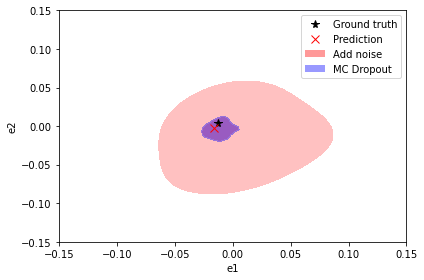

In [ ]:
#for k in [520, 5870, 3630]:
for k in [520]:
  kde(k)

In [69]:
from PIL import Image
import imageio
b = np.load(H_d+'../result_correct/new_data_blur_clamp.npz')
#p = np.load(H_d+'../result_correct/new_data_kernel_clamp_channele.npz')
print(b['img_blur'].shape)
print(b['img_kernel'].shape)
print(b['img_true'].shape)
print(b['img_pred'].shape)

(10000, 3, 32, 32)
(10000, 3, 35, 35)
(10000, 3, 32, 32)
(10000, 3, 32, 32)


In [67]:
def kde(k, ax):
  # Additive noise
  x1 = e1_noise_n[k]
  y1 = e2_noise_n[k]

  # MC dropout
  x2 = e1_noise_d[k]
  y2 = e2_noise_d[k]

  xmin, xmax = min(x1.min(), x2.min()), max(x1.max(), x2.max())
  ymin, ymax = min(y1.min(), y2.min()), max(y1.max(), y2.max())

  print(xmin, xmax)
  print(ymin, ymax)

###################################################
###################################################

  # Peform the kernel density estimate
  xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
  positions = np.vstack([xx.ravel(), yy.ravel()])

  values1 = np.vstack([x1, y1])
  kernel1 = st.gaussian_kde(values1)
  f1 = np.reshape(kernel1(positions).T, xx.shape)

  values2 = np.vstack([x2, y2])
  kernel2 = st.gaussian_kde(values2)
  f2 = np.reshape(kernel2(positions).T, xx.shape)

  # Plotting
  #fig = plt.figure()
  #ax = fig.gca()
  ax.set_xlim(xmin, xmax)
  ax.set_ylim(ymin, ymax)

  # Contourf plot
  cfset1 = ax.contourf(xx, yy, f1, levels=1, colors=['w', 'r'], alpha=0.4)

  # # or kernel density estimate plot instead of the contourf plot
  # ax.imshow(np.rot90(f1), cmap='Reds', extent=[xmin, xmax, ymin, ymax])

  cfset2 = ax.contourf(xx, yy, f2, levels=1, colors=['w', 'b'], alpha=0.4)
  # # or kernel density estimate plot instead of the contourf plot
  # ax.imshow(np.rot90(f2), cmap='Blues', extent=[xmin, xmax, ymin, ymax])
 
  m1, = plt.plot(e1_true_n[k], e2_true_n[k], '*', color = 'k', markersize = 8, linewidth=10, label='Ground Truth')
  m2, = plt.plot(e1_pred_d[k], e2_pred_d[k], 'x', color = 'r', markersize = 8, linewidth=10, label='Prediction')
  
  ax.set_xlabel('e1')
  ax.set_ylabel('e2')

  proxy = [m1, m2, plt.Rectangle((1, 1), 2, 2, fc=cfset1.collections[1].get_facecolor()[0]), plt.Rectangle((1, 1), 2, 2, fc=cfset2.collections[1].get_facecolor()[0])]
  plt.legend(proxy, ['Target', 'prediction', "Add noise", "MC Dropout"])
  
def plot(k):
  true_img=b['img_true'][k].clip(0,1.)
  deblur_img=b['img_pred'][k].clip(0,1.)
  blur_img=b['img_blur'][k].clip(0,1.)
  kernel_img=b['img_kernel'][k].clip(0,1.)

  kernel = np.transpose(kernel_img, (1, 2, 0))#/kernel.max()
  blur = np.transpose(blur_img, (1, 2, 0))#/blur.max()
  deblur = np.transpose(deblur_img, (1, 2, 0))#/deblur.max()
  true = np.transpose(true_img, (1, 2, 0))#/true.max()

  fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
  #plt.subplot(1,5,1)
  ax1.imshow(blur/blur.max(), interpolation='nearest')
  ax1.text(1., 4.5, '%.3f'%blur.max(), size=8, color='w')
  #ax1.title('Blurred image')
  ax1.text(0.5, -0.15, 'Blurred image', size=8, ha='center', transform=ax1.transAxes)
  ax1.axis('off')

  ax2.imshow(kernel/kernel.max(), interpolation='nearest')
  ax2.text(1., 4.5, '%.3f'%kernel.max(), size=8, color='w')
  ax2.text(0.5, -0.15, 'PSF', size=8, ha='center', transform=ax2.transAxes)
  #plt.title('PSF')
  ax2.axis('off')

  #plt.subplot(1,4,4)
  ax3.imshow(true/true.max(), interpolation='nearest')
  ax3.text(1., 4.5, '%.3f'%true.max(), size=8, color='w')
  ax3.text(0.5, -0.15, 'Ground Truth', size=8, ha='center', transform=ax3.transAxes)
  #ax3.title('True image')
  ax3.axis('off')

  #plt.subplot(1,4,3)
  ax4.imshow(deblur/deblur.max(), interpolation='nearest')
  ax4.text(1., 4.5, '%.3f'%deblur.max(), size=8, color='w')
  ax4.text(0.5, -0.15, 'Prediction', size=8, ha='center', transform=ax4.transAxes)
  #ax4.title('Prediction')
  ax4.axis('off')

  #kde(k, ax5)
  print(true.shape)

  #plt.imshow(blur/blur.max())
  #plt.imshow(kernel/kernel.max())
  #plt.imshow(true/true.max())
  #plt.imshow(deblur/deblur.max())
  plt.tight_layout()
  plt.savefig(H_d+str(k)+'.png',bbox_inches='tight')
#im=Image.fromarray((true_img/true_img.max()*255).astype(np.uint8))
#im.save(H+'true.png')
#im=Image.fromarray((deblur_img/deblur_img.max()*255).astype(np.uint8))
#im.save(H+'deblur.png')
#imageio.imwrite(H+'true.png', true_img/true_img.max())
#imageio.imwrite(H+'deblur.png', deblur_img/deblur_img.max())
#imageio.imwrite(H+'blur.png', blur_img/blur_img.max())
#imageio.imwrite(H+'kernel.png', kernel_img/kernel_img.max())


(32, 32, 3)


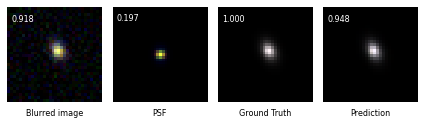

In [71]:
#for k in [520, 5870, 3630]:
for k in [8500]:
  plot(k)

(100, 2)
(100,) (100,)
[[-2.         -2.         -2.         ... -2.         -2.
  -2.        ]
 [-1.95959596 -1.95959596 -1.95959596 ... -1.95959596 -1.95959596
  -1.95959596]
 [-1.91919192 -1.91919192 -1.91919192 ... -1.91919192 -1.91919192
  -1.91919192]
 ...
 [ 1.91919192  1.91919192  1.91919192 ...  1.91919192  1.91919192
   1.91919192]
 [ 1.95959596  1.95959596  1.95959596 ...  1.95959596  1.95959596
   1.95959596]
 [ 2.          2.          2.         ...  2.          2.
   2.        ]] [[-2.         -1.95959596 -1.91919192 ...  1.91919192  1.95959596
   2.        ]
 [-2.         -1.95959596 -1.91919192 ...  1.91919192  1.95959596
   2.        ]
 [-2.         -1.95959596 -1.91919192 ...  1.91919192  1.95959596
   2.        ]
 ...
 [-2.         -1.95959596 -1.91919192 ...  1.91919192  1.95959596
   2.        ]
 [-2.         -1.95959596 -1.91919192 ...  1.91919192  1.95959596
   2.        ]
 [-2.         -1.95959596 -1.91919192 ...  1.91919192  1.95959596
   2.        ]]
p [[-2.  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: covariance is not positive-semidefinite.
  


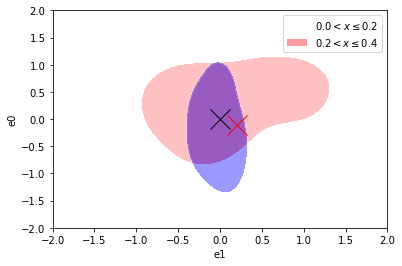

In [ ]:
# Additive noise
data1 = np.random.multivariate_normal((0, 0), [[0.8, 0.05], [0.05, 0.7]], 100)
x1 = data1[:, 0]
y1 = data1[:, 1]
print(data1.shape)
print(x1.shape, y1.shape)
# # MC dropout
data2 = np.random.multivariate_normal((0, 0), [[0.2, 0.03], [0.09, 1.1]], 100)
x2 = data2[:, 0]
y2 = data2[:, 1]

xmin, xmax = -2, 2
ymin, ymax = -2, 2

###################################################
###################################################

 # Peform the kernel density estimate
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])
print(xx, yy)
print('p', positions)
values1 = np.vstack([x1, y1])
kernel1 = st.gaussian_kde(values1)
f1 = np.reshape(kernel1(positions).T, xx.shape)

values2 = np.vstack([x2, y2])
kernel2 = st.gaussian_kde(values2)
f2 = np.reshape(kernel2(positions).T, xx.shape)

# Plotting
fig = plt.figure()
ax = fig.gca()
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

# Contourf plot
cfset1 = ax.contourf(xx, yy, f1, levels=1, colors=['w', 'r'], alpha=0.4)

## or kernel density estimate plot instead of the contourf plot
# ax.imshow(np.rot90(f1), cmap='Reds', extent=[xmin, xmax, ymin, ymax])

cfset2 = ax.contourf(xx, yy, f2, levels=1, colors=['w', 'b'], alpha=0.4)
## or kernel density estimate plot instead of the contourf plot
# ax.imshow(np.rot90(f2), cmap='Blues', extent=[xmin, xmax, ymin, ymax])

m1 = plt.plot(0, 0, 'x', color = 'k', markersize = 20, linewidth=10, label='Target')
m2 = plt.plot(0.2, -0.1, 'x', color = 'r', markersize = 20, linewidth=10, label='Best pred')

ax.set_xlabel('e1')
ax.set_ylabel('e0')

proxy = [plt.Rectangle((1, 1), 2, 2, fc=pc.get_facecolor()[0]) for pc in cfset1.collections]
plt.legend(proxy, ["Additional Noise", "MC Dropout"])

plt.legend()
plt.legend(cfset1.legend_elements()[0], cfset2.legend_elements()[1])

plt.show()

In [ ]:
print(type(x1))

<class 'numpy.ndarray'>
